# 3.2

## 1

In [25]:
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from scipy.ndimage.filters import convolve
from skimage.color import rgb2gray
import cv2 as cv
from skimage.measure import regionprops
from skimage.segmentation import flood, flood_fill
from skimage.measure import label
import sknw
from skimage.morphology import skeletonize, medial_axis, thin

In [26]:
def Hessian2D(I, Sigma=1):
    """
    This function Hessian2 filters the image with 2nd derivatives of a
    Gaussian with parameter Sigma.
    :param I: image, in flotaing point precision (float64)
    :param Sigma: sigma of the gaussian kernel used
    :return: the 2nd derivatives
    """
    # Make kernel coordinates
    X, Y = np.meshgrid(np.arange(-np.round(3*Sigma), np.round(3*Sigma) +1),
                       np.arange(-np.round(3*Sigma), np.round(3*Sigma) +1), indexing='ij')

    # Build the gaussian 2nd derivatives filters
    DGaussxx = 1/(2*np.pi*Sigma**4)*(X**2/Sigma**2 - 1)*np.exp(-(X**2 + Y**2)/(2*Sigma**2))
    DGaussxy = (1/(2*np.pi*Sigma**6))*(X*Y)*np.exp(-(X**2 + Y**2)/(2*Sigma**2))
    DGaussyy = DGaussxx.conj().T

    Dxx = convolve(I, DGaussxx, mode='constant', cval=0.0)
    Dxy = convolve(I, DGaussxy, mode='constant', cval=0.0)
    Dyy = convolve(I, DGaussyy, mode='constant', cval=0.0)

    return Dxx, Dxy, Dyy

In [27]:
def eig2image(Dxx, Dxy, Dyy):
    """
    This function eig2image calculates the eigen values from the
    hessian matrix, sorted by abs value. And gives the direction
    of the ridge (eigenvector smallest eigenvalue) .
    | Dxx  Dxy |
    | Dxy  Dyy |
    """
    # Compute the eigenvectors of J, v1 and v2
    tmp = np.sqrt((Dxx - Dyy)**2 + 4*Dxy**2)
    v2x = 2*Dxy
    v2y = Dyy - Dxx + tmp

    # Normalize
    mag = np.sqrt(v2x**2 + v2y**2)
    i = np.invert(np.isclose(mag, np.zeros(mag.shape)))
    v2x[i] = v2x[i]/mag[i]
    v2y[i] = v2y[i]/mag[i]

    # The eigenvectors are orthogonal
    v1x = -v2y.copy()
    v1y = v2x.copy()

    # Compute the eigenvalues
    mu1 = 0.5*(Dxx + Dyy + tmp)
    mu2 = 0.5*(Dxx + Dyy - tmp)

    # Sort eigenvalues by absolute value abs(Lambda1)<abs(Lambda2)
    check = np.absolute(mu1) > np.absolute(mu2)

    Lambda1 = mu1.copy()
    Lambda1[check] = mu2[check]
    Lambda2 = mu2.copy()
    Lambda2[check] = mu1[check]

    Ix = v1x.copy()
    Ix[check] = v2x[check]
    Iy = v1y.copy()
    Iy[check] = v2y[check]

    return Lambda1, Lambda2, Ix, Iy

In [28]:
def FrangiFilter2D(I, FrangiScaleRange=np.array([1, 10]), FrangiScaleRatio=2,
                   FrangiBetaOne=0.5, FrangiBetaTwo=15, verbose=False, BlackWhite=True):
    """
    This function FRANGIFILTER2D uses the eigenvectors of the Hessian to
    compute the likeliness of an image region to vessels, according
    to the method described by Frangi:2001 (Chapter 2). Adapted from MATLAB code
    :param I: imput image (grayscale)
    :param FrangiScaleRange: The range of sigmas used, default [1 10]
    :param FrangiScaleRatio: Step size between sigmas, default 2
    :param FrangiBetaOne: Frangi correction constant, default 0.5
    :param FrangiBetaTwo: Frangi correction constant, default 15
    :param verbose: Show debug information, default false
    :param BlackWhite: Detect black ridges (default) set to true, for white ridges set to false.
    :return: The vessel enhanced image (pixel is the maximum found in all scales)
    """

    if len(FrangiScaleRange) > 1:
        sigmas = np.arange(FrangiScaleRange[0], FrangiScaleRange[1]+1, FrangiScaleRatio)
        sigmas = sorted(sigmas)
    else:
        sigmas = [FrangiScaleRange[0]]
    beta = 2*FrangiBetaOne**2
    c = 2*FrangiBetaTwo**2

    # Make matrices to store all filterd images
    ALLfiltered = np.zeros([I.shape[0], I.shape[1], len(sigmas)])
    ALLangles = np.zeros([I.shape[0], I.shape[1], len(sigmas)])

    # Frangi filter for all sigmas
    for i in range(len(sigmas)):
        # Show progress
        if verbose:
            print('Current Frangi Filter Sigma: ', str(sigmas[i]))

        # Make 2D hessian
        Dxx, Dxy, Dyy = Hessian2D(I, sigmas[i])

        # Correct for scale
        Dxx *= (sigmas[i]**2)
        Dxy *= (sigmas[i]**2)
        Dyy *= (sigmas[i]**2)

        # Calculate (abs sorted) eigenvalues and vectors
        Lambda2, Lambda1, Ix, Iy = eig2image(Dxx, Dxy, Dyy)

        # Compute the direction of the minor eigenvector
        angles = np.arctan2(Ix, Iy)

        # Compute some similarity measures
        near_zeros = np.isclose(Lambda1, np.zeros(Lambda1.shape))
        Lambda1[near_zeros] = 2**(-52)
        Rb = (Lambda2/Lambda1)**2
        S2 = Lambda1**2 + Lambda2**2

        # Compute the output image
        Ifiltered = np.exp(-Rb/beta)*(np.ones(I.shape)-np.exp(-S2/c))

        # see pp. 45
        if BlackWhite:
            Ifiltered[Lambda1 < 0] = 0
        else:
            Ifiltered[Lambda1 > 0] = 0

        # store the results in 3D matrices
        ALLfiltered[:, :, i] = Ifiltered.copy()
        ALLangles[:, :, i] = angles.copy()


    # Return for every pixel the value of the scale(sigma) with the maximum
    # output pixel value
    if len(sigmas) > 1:
        outIm = np.amax(ALLfiltered, axis=2)
        outIm = outIm.reshape(I.shape[0], I.shape[1], order='F')
        whatScale = np.argmax(ALLfiltered, axis=2)
        whatScale = np.reshape(whatScale, I.shape, order='F')

        indices = range(I.size) + (whatScale.flatten(order='F') - 1)*I.size
        values = np.take(ALLangles.flatten(order='F'), indices)
        direction = np.reshape(values, I.shape, order='F')
    else:
        outIm = ALLfiltered.reshape(I.shape[0], I.shape[1], order='F')
        whatScale = np.ones(I.shape)
        direction = np.reshape(ALLangles, I.shape, order='F')

    return outIm, whatScale, direction

(-0.5, 3503.5, 2335.5, -0.5)

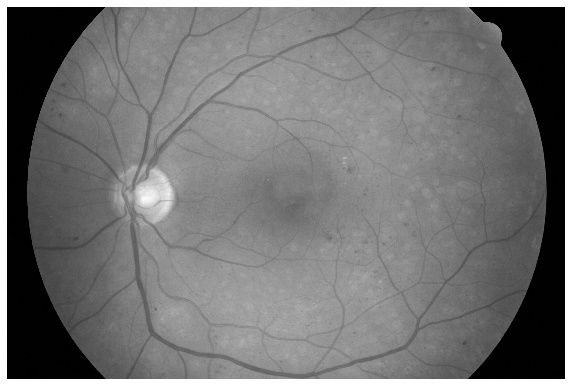

In [29]:
im = imread('images/01_dr.JPG')
mask_first = imread('mask/01_dr_mask.tif')

grayscale_mask = rgb2gray(mask_first).astype(np.uint8)
grayscale = rgb2gray(im)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(grayscale, cmap='gray')
ax.axis('off')

(-0.5, 3503.5, 2335.5, -0.5)

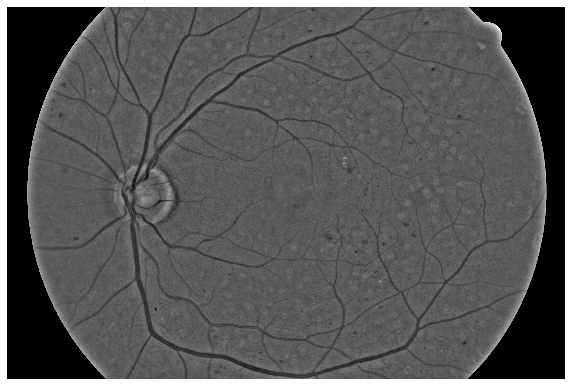

In [30]:
from skimage.exposure import rescale_intensity

blur = cv.GaussianBlur(grayscale,(201,201),0)
filtered = cv.subtract(grayscale, blur, mask=grayscale_mask)
filtered[grayscale_mask == 0] = filtered.min()

filtered = rescale_intensity(filtered, in_range='image', out_range=np.uint8)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(filtered, cmap='gray')
ax.axis('off')

## 2

Current Frangi Filter Sigma:  3
Current Frangi Filter Sigma:  4
Current Frangi Filter Sigma:  5
Current Frangi Filter Sigma:  6
Current Frangi Filter Sigma:  7
Current Frangi Filter Sigma:  8
Current Frangi Filter Sigma:  9
Current Frangi Filter Sigma:  10


(-0.5, 3503.5, 2335.5, -0.5)

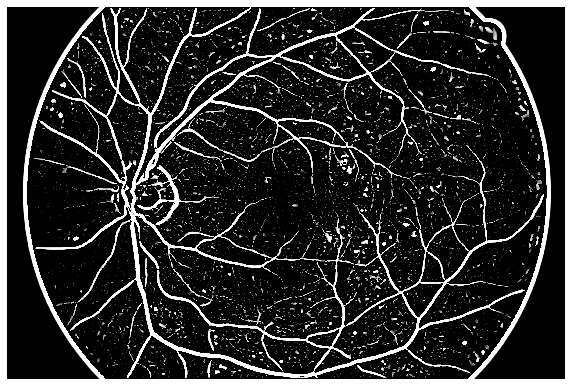

In [38]:
out_img, _, _ = FrangiFilter2D(filtered, FrangiScaleRange=np.array([3, 10]), FrangiScaleRatio=1, FrangiBetaOne=20, FrangiBetaTwo=2, verbose=True)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(out_img, cmap='gray')
ax.axis('off')

(-0.5, 3503.5, 2335.5, -0.5)

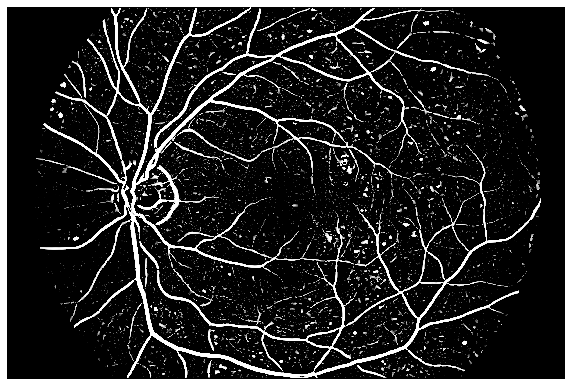

In [39]:
out_img[grayscale_mask == 0] = 0
result = out_img.copy()
result = rescale_intensity(result, in_range='image', out_range=np.uint8).astype(np.uint8)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(out_img, cmap='gray')
ax.axis('off')

## 3

Text(0.5, -0.1, 'Small blobs removed')

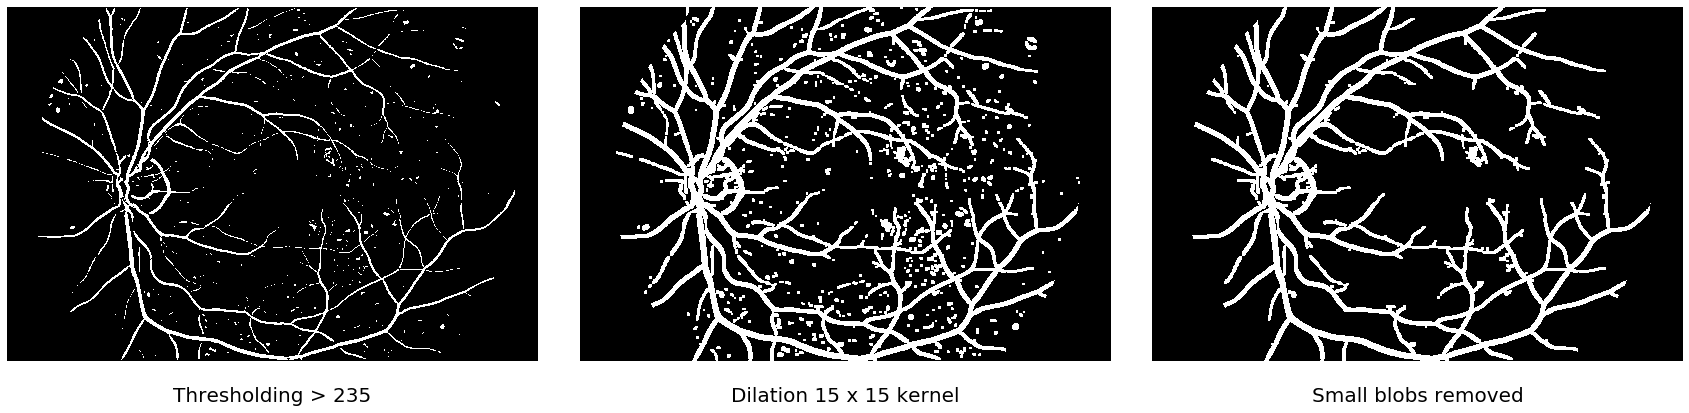

In [46]:
from skimage.filters import threshold_otsu

#thresh = threshold_otsu(result)
binary = (result > 235).astype(np.uint8) * 255

kernel_dilation = np.ones((15, 15), np.uint8)
dilated = cv.dilate(binary, kernel_dilation)

kernel_erosion = np.ones((15, 15), np.uint8)
grayscale_mask = cv.erode(grayscale_mask, kernel_erosion)
dilated[grayscale_mask == 0] = 0

closed_reduced = dilated.copy()
closed_labeled = label(closed_reduced)
for region in regionprops(closed_labeled):
    if region.area < 7000:
        closed_reduced = flood_fill(closed_reduced, tuple(region.coords[0, :]), 0)

closed_reduced = (closed_reduced / 255).astype(np.uint8)

fig, ax = plt.subplots(1, 3, figsize=(24, 40))
fig.tight_layout()
ax[0].imshow(binary, cmap='gray')
ax[0].axis('off')
ax[0].text(0.5, -0.1, 'Thresholding > 235', horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes, fontsize=20)
ax[1].imshow(dilated, cmap='gray')
ax[1].axis('off')
ax[1].text(0.5, -0.1, 'Dilation 15 x 15 kernel', horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes, fontsize=20)
ax[2].imshow(closed_reduced, cmap='gray')
ax[2].axis('off')
ax[2].text(0.5, -0.1, 'Small blobs removed', horizontalalignment='center', verticalalignment='center', transform=ax[2].transAxes, fontsize=20)

# 3.3

## 1

(-0.5, 499.5, 499.5, -0.5)

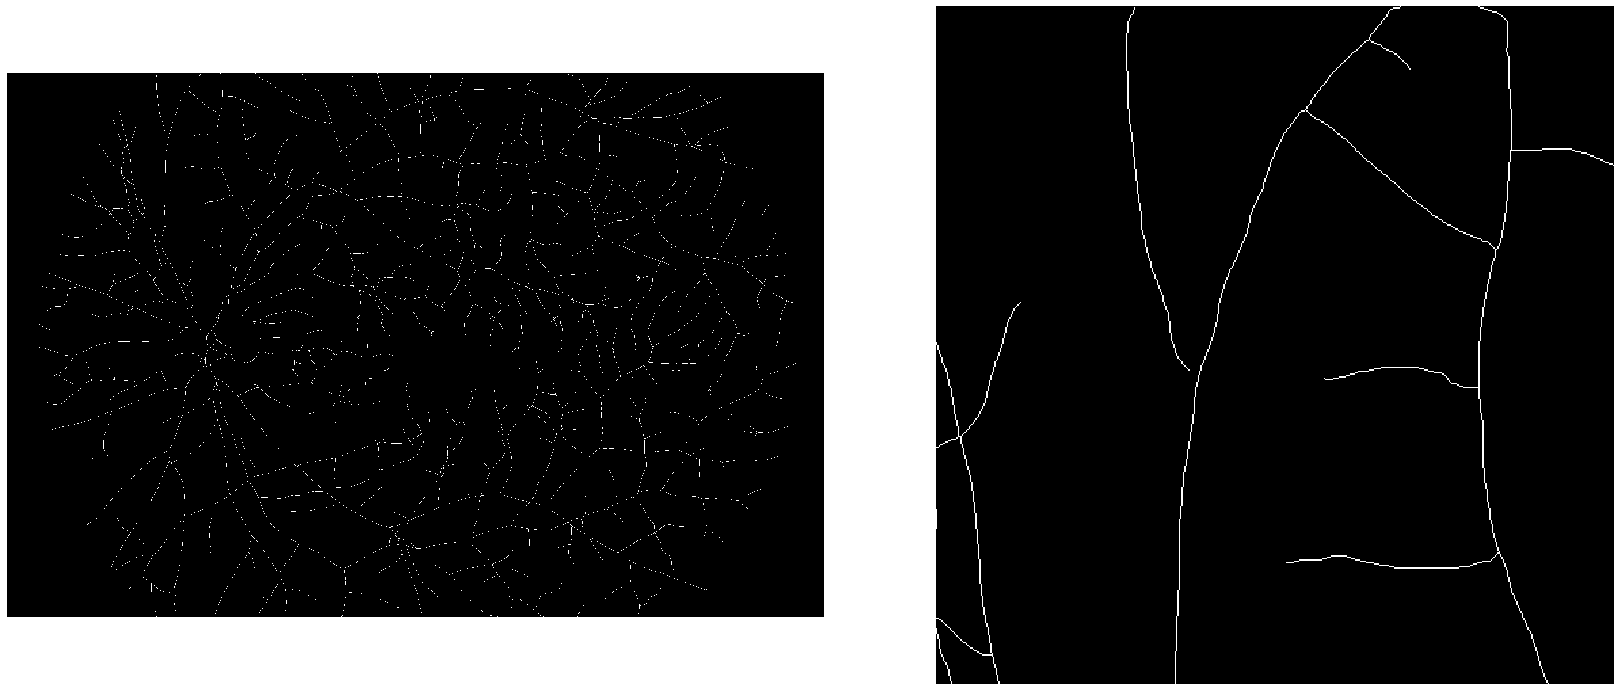

In [31]:
im_gt = (imread('manual1/08_g.tif') / 255).astype(np.uint8)

skeleton = skeletonize(im_gt)

fig, ax = plt.subplots(1, 2, figsize=(24, 10))
fig.tight_layout()
ax[0].imshow(skeleton, cmap='gray')
ax[0].axis('off')
ax[1].imshow(skeleton[:500, 500:1000], cmap='gray')
ax[1].axis('off')


## 2

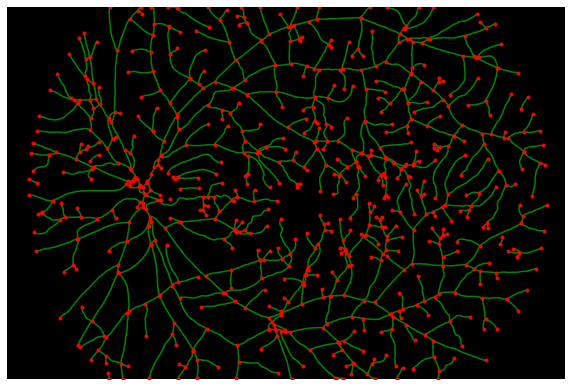

In [28]:
graph = sknw.build_sknw(skeleton)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(skeleton, cmap='gray')
ax.axis('off')

for (s,e) in graph.edges():
    ps = graph[s][e]['pts']
    ax.plot(ps[:,1], ps[:,0], 'green')

nodes = graph.nodes()
ps = np.array([nodes[i]['o'] for i in nodes])
ax.plot(ps[:,1], ps[:,0], 'r.')

## 3

(-0.5, 499.5, 499.5, -0.5)

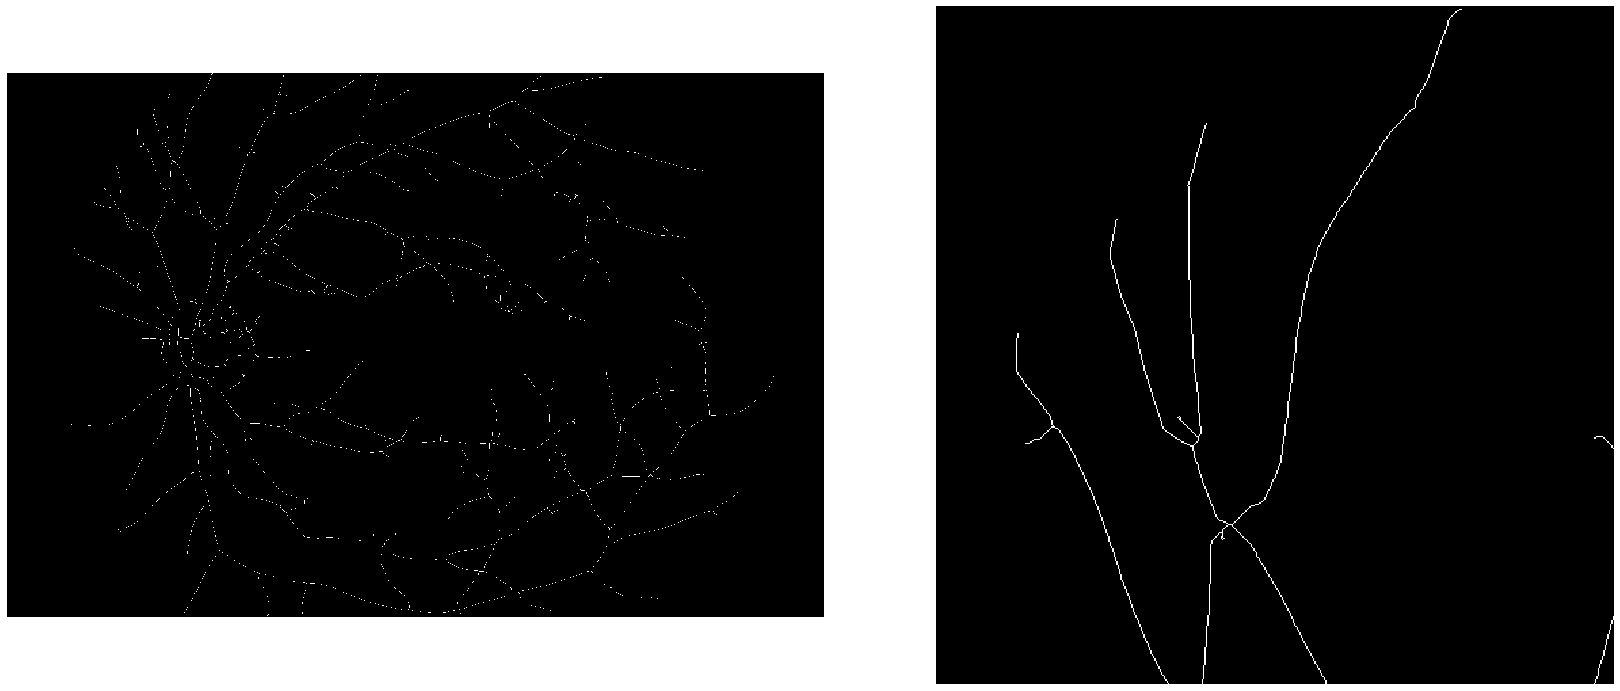

In [47]:
skeleton = skeletonize(closed_reduced)

fig, ax = plt.subplots(1, 2, figsize=(24, 10))
fig.tight_layout()
ax[0].imshow(skeleton, cmap='gray')
ax[0].axis('off')
ax[1].imshow(skeleton[:500, 500:1000], cmap='gray')
ax[1].axis('off')

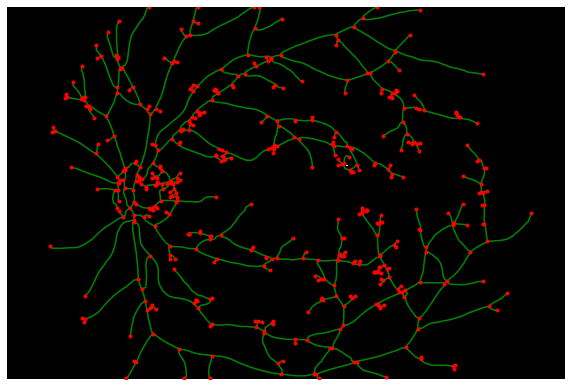

In [48]:
graph = sknw.build_sknw(skeleton)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(skeleton, cmap='gray')
ax.axis('off')

for (s,e) in graph.edges():
    ps = graph[s][e]['pts']
    ax.plot(ps[:,1], ps[:,0], 'green')

nodes = graph.nodes()
ps = np.array([nodes[i]['o'] for i in nodes])
ax.plot(ps[:,1], ps[:,0], 'r.')